In [544]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [545]:
def filter_printable(s):
    return ''.join(filter(str.isprintable, s))

In [546]:
statuses_df = pd.read_csv('./ID-status.csv', sep=';', encoding='cp1251')
statuses_df = statuses_df.rename(columns={'PTYPE': 'STATUS'})
# statuses_df = statuses_df[statuses_df.STATUS.isin([2, 3])]
statuses_df.STATUS = statuses_df.STATUS.map({1: 0, 2: 0, 3: 1})  # 0 - выпускник, 1 - отчислен
statuses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75351 entries, 0 to 75350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   STDID   75351 non-null  int64
 1   STATUS  75351 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [547]:
certs_df = pd.read_csv('./all_cert.csv', sep=';', encoding='cp1251', decimal=',')
certs_df.FACID = certs_df.FACID.apply(filter_printable).astype('int64')
bad_stdid = set(certs_df.STDID[
    certs_df.FACID.isin([1975, 1976]) | certs_df.C_AT.isna() | certs_df.C_NAT.isna() | (certs_df.MARK > 5)])
certs_df = certs_df[~certs_df.STDID.isin(bad_stdid)]
certs_df.STDID = certs_df.STDID.apply(filter_printable).astype('int64')
certs_df.GROUPID = certs_df.GROUPID.apply(filter_printable).astype('int64')
certs_df.C_AT = certs_df.C_AT.astype('int64')
certs_df.C_NAT = certs_df.C_NAT.astype('int64')
certs_df.SUBJECTID = certs_df.SUBJECTID.apply(filter_printable).astype('int64')
certs_df.MARK = certs_df.MARK.astype('int64')
certs_df.head()

,STDID,SEX,YBIRTH,EYEAR,FACID,GROUPID,SEMESTR,WEEK,WEEKCAPTION,C_AT,C_NAT,SUBJECTID,SUBJECTNAME,SNAME,MARK
0,67103,1,1993,2012,1967,8721,1,7,15.10.12 - 21.10.12,0,1,1,Иностранный язык,Ин. яз.,2
1,67103,1,1993,2012,1967,8721,1,7,15.10.12 - 21.10.12,0,1,2,Физическая культура,Физ.культ.,4
2,67103,1,1993,2012,1967,8721,1,7,15.10.12 - 21.10.12,0,1,4,Математика,Математика,0
3,67103,1,1993,2012,1967,8721,1,7,15.10.12 - 21.10.12,0,1,6,Философия,Философия,2
4,67103,1,1993,2012,1967,8721,1,7,15.10.12 - 21.10.12,0,1,20,Информатика,Информатика,2


In [548]:
certs_df = certs_df.merge(statuses_df, on='STDID', how='inner')
certs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182970 entries, 0 to 1182969
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   STDID        1182970 non-null  int64 
 1   SEX          1182970 non-null  int64 
 2   YBIRTH       1182970 non-null  int64 
 3   EYEAR        1182970 non-null  int64 
 4   FACID        1182970 non-null  int64 
 5   GROUPID      1182970 non-null  int64 
 6   SEMESTR      1182970 non-null  int64 
 7   WEEK         1182970 non-null  int64 
 8   WEEKCAPTION  1182970 non-null  object
 9   C_AT         1182970 non-null  int64 
 10  C_NAT        1182970 non-null  int64 
 11  SUBJECTID    1182970 non-null  int64 
 12  SUBJECTNAME  1182970 non-null  object
 13  SNAME        1182970 non-null  object
 14  MARK         1182970 non-null  int64 
 15  STATUS       1182970 non-null  int64 
dtypes: int64(13), object(3)
memory usage: 153.4+ MB


In [549]:
certs_df['TWEEK'] = (certs_df.SEMESTR-1) * 39 + certs_df.WEEK

In [633]:
groupby_df = certs_df.groupby(['STDID', 'TWEEK'])
df = pd.concat([
    groupby_df['FACID', 'SEX', 'YBIRTH', 'STATUS', 'C_AT', 'C_NAT'].first(), 
    groupby_df.agg({'MARK': np.mean})]
, axis=1).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122677 entries, 0 to 122676
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   STDID   122677 non-null  int64  
 1   TWEEK   122677 non-null  int64  
 2   FACID   122677 non-null  int64  
 3   SEX     122677 non-null  int64  
 4   YBIRTH  122677 non-null  int64  
 5   STATUS  122677 non-null  int64  
 6   C_AT    122677 non-null  int64  
 7   C_NAT   122677 non-null  int64  
 8   MARK    122677 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 8.4 MB
/home/sergey/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [634]:
def ewma(a, alpha):
    wghts = (1-alpha)**np.arange(len(a))
    wghts /= np.sum(wghts)
    wghts *= alpha
    out = np.ma.average(a, weights=wghts)
    return out

def trend(y, x=None):
    y_diff = y.iloc[1:].values - y.iloc[:-1].values
    if x is not None:
        y_diff /= x.iloc[1:].values - x.iloc[:-1].values
    # print(type(y_diff), y_diff)
    # return pd.Series(y_diff).ewm(alpha=0.25).mean().iloc[-1] if len(y) > 1 else 0
    return np.mean(y_diff) if len(y) > 1 else 0

def minmax_diff(x):
    return np.max(x) - np.min(x)

df.groupby('STDID').apply(lambda row: trend(row['C_AT']))
df_extra = df.groupby('STDID').agg({
    'C_AT': np.mean,
    'C_NAT': np.mean,
    'MARK': [np.min, np.mean, minmax_diff],
})
df_extra['C_AT_trend'] = df.groupby('STDID').apply(lambda row: trend(row['C_AT']))
df_extra['C_NAT_trend'] = df.groupby('STDID').apply(lambda row: trend(row['C_NAT']))
df_extra['MARK_trend'] = df.groupby('STDID').apply(lambda row: trend(row['MARK'], row['TWEEK']))
df_extra.columns = ['C_AT_mean', 'C_NAT_mean', 'MARK_min', 'MARK_mean', 'MARK_minmax_diff', 'C_AT_trend', 'C_NAT_trend', 'MARK_trend']

In [635]:
df_extra

,C_AT_mean,C_NAT_mean,MARK_min,MARK_mean,MARK_minmax_diff,C_AT_trend,C_NAT_trend,MARK_trend
STDID,,,,,,,,
4,1.333333,1.000000,1.700,2.506271,1.425000,0.00,0.0,-0.022249
2774,0.000000,1.000000,3.625,4.205087,1.089286,0.00,0.0,0.017273
2778,0.000000,1.000000,2.875,3.781667,1.625000,0.00,0.0,-0.008314
2791,0.000000,1.000000,3.500,3.869213,0.750000,0.00,0.0,-0.001910
2792,0.000000,1.000000,3.200,3.877121,1.466667,0.00,0.0,0.008477
...,...,...,...,...,...,...,...,...
112003,0.000000,50.333333,0.000,1.190476,2.000000,0.00,-36.4,-0.018836
112021,0.200000,0.400000,0.000,1.782857,3.200000,0.25,0.5,0.206433
112099,0.000000,0.000000,0.000,3.464286,4.857143,0.00,0.0,-0.232804


In [636]:
sessions_df_backup = pd.read_csv('./all_session.csv', sep=';', encoding='cp1251', decimal=',')

In [637]:
sessions_df = sessions_df_backup
sessions_df.MARK = sessions_df.MARK.astype('int64')
sessions_df.head()

,STDID,SEX,YBIRTH,EYEAR,FACID,NSEMESTR,SUBJECTID,SEXAMID,SUBJECTNAME,MARK,...,MARKNAME,SDATE,DIFF_Z,TYPEID,ISGOOD,THOUR,AH,SAM,ATTCOUNT,O_INSESSION
0,51620,1,1987,2009,1975,4,397,74198,Механика жидкости и газа,-1,...,Неявка,NaN,0,1.0,0,78.0,8.0,70.0,1,1
1,51620,1,1987,2009,1975,4,1,74199,Иностранный язык,-1,...,Неявка,NaN,0,1.0,0,164.0,8.0,156.0,1,1
2,51620,1,1987,2009,1975,4,2,74200,Физическая культура,-1,...,Неявка,NaN,0,1.0,0,408.0,10.0,398.0,1,1
3,51620,1,1987,2009,1975,4,4,74201,Математика,-1,...,Неявка,NaN,0,1.0,0,261.0,12.0,249.0,1,1
4,51620,1,1987,2009,1975,4,29,74202,Теоретическая механика,-1,...,Неявка,NaN,0,1.0,0,192.0,12.0,180.0,1,1


In [638]:
def positive_mean(x):
    return np.mean(x[x >= 0]) if len(x[x >= 0]) > 0 else 0

def negative_count(x):
    return np.sum(x < 0)

sessions_df = sessions_df.groupby(['STDID', 'NSEMESTR']).agg({
    'MARK': [positive_mean, negative_count],
    'O_INSESSION': np.sum,
    'ATTCOUNT': [np.mean, np.sum]

})
sessions_df.columns = ['MARK_positive_mean', 'MARK_negative_count', 'O_INSESSION', 'ATTCOUNT_mean', 'ATTCOUNT_sum']
sessions_df = sessions_df.reset_index()

In [639]:
sessions_df = sessions_df.groupby('STDID').agg({
    'MARK_positive_mean': [np.mean, trend],
    'MARK_negative_count': [np.mean, trend],
    'O_INSESSION': [np.mean, trend],
    'ATTCOUNT_mean': [np.mean, trend],
    'ATTCOUNT_sum': [np.mean, trend],
})
from itertools import chain
sessions_df.columns = list(chain.from_iterable(['%s_mean' % x, '%s_trend' % x]
                                                for x in sessions_df.droplevel(1, axis=1).columns[::2]))

In [640]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14791 entries, 4 to 112170
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MARK_positive_mean_mean    14791 non-null  float64
 1   MARK_positive_mean_trend   14791 non-null  float64
 2   MARK_negative_count_mean   14791 non-null  float64
 3   MARK_negative_count_trend  14791 non-null  float64
 4   O_INSESSION_mean           14791 non-null  float64
 5   O_INSESSION_trend          14791 non-null  float64
 6   ATTCOUNT_mean_mean         14791 non-null  float64
 7   ATTCOUNT_mean_trend        14791 non-null  float64
 8   ATTCOUNT_sum_mean          14791 non-null  float64
 9   ATTCOUNT_sum_trend         14791 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [641]:
df = df.groupby('STDID').first().reset_index().join(df_extra, on='STDID').join(sessions_df, on='STDID', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 13538
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STDID                      7522 non-null   int64  
 1   TWEEK                      7522 non-null   int64  
 2   FACID                      7522 non-null   int64  
 3   SEX                        7522 non-null   int64  
 4   YBIRTH                     7522 non-null   int64  
 5   STATUS                     7522 non-null   int64  
 6   C_AT                       7522 non-null   int64  
 7   C_NAT                      7522 non-null   int64  
 8   MARK                       7522 non-null   float64
 9   C_AT_mean                  7522 non-null   float64
 10  C_NAT_mean                 7522 non-null   float64
 11  MARK_min                   7522 non-null   float64
 12  MARK_mean                  7522 non-null   float64
 13  MARK_minmax_diff           7522 non-null   floa

In [642]:
df.head()#isna().sum()

,STDID,TWEEK,FACID,SEX,YBIRTH,STATUS,C_AT,C_NAT,MARK,C_AT_mean,...,MARK_positive_mean_mean,MARK_positive_mean_trend,MARK_negative_count_mean,MARK_negative_count_trend,O_INSESSION_mean,O_INSESSION_trend,ATTCOUNT_mean_mean,ATTCOUNT_mean_trend,ATTCOUNT_sum_mean,ATTCOUNT_sum_trend
0,4,8,19585,1,1992,0,0,1,3.125000,1.333333,...,2.847063,0.277778,0.0,0.000000,10.3,-1.000000,1.039091,0.000000,10.4,-0.777778
1,2774,68,3,1,1986,0,0,1,3.625000,0.000000,...,3.349026,0.282828,0.0,0.000000,10.3,-1.222222,1.042468,-0.010101,10.8,-1.222222
2,2778,87,3,1,1986,0,0,1,3.700000,0.000000,...,3.004623,0.161616,0.0,0.000000,11.7,-1.333333,1.038004,0.000000,11.2,-1.111111
3,2791,67,20,0,1985,0,0,1,3.666667,0.000000,...,3.077409,0.333333,0.3,-0.111111,10.0,-1.000000,1.020202,0.000000,10.5,-1.000000
4,2792,87,3,1,1987,0,0,1,3.200000,0.000000,...,3.335040,0.262626,0.0,0.000000,10.6,-1.111111,1.008333,0.000000,10.8,-1.111111


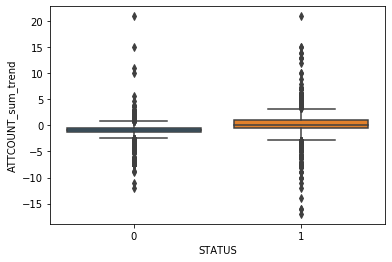

In [643]:
sns.boxplot(x='STATUS', y='ATTCOUNT_sum_trend', data=df)

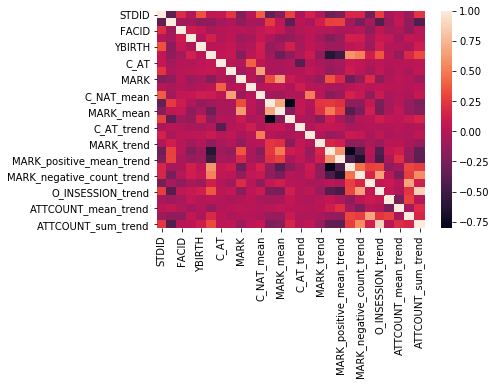

In [644]:
sns.heatmap(df.corr())

In [645]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [787]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
features = [
    'SEX', 'YBIRTH',
    'C_AT_mean', 'C_NAT_mean', 'MARK_min', 'MARK_mean', 'MARK_minmax_diff', 'C_AT_trend', 'C_NAT_trend', 'MARK_trend', # аттестация
    # 'MARK_positive_mean_mean', 'MARK_negative_count_mean', 'O_INSESSION_mean', 'ATTCOUNT_mean_mean', 'ATTCOUNT_sum_mean',
    'MARK_positive_mean_trend', 'MARK_negative_count_trend', 'O_INSESSION_trend', 'ATTCOUNT_mean_trend', 'ATTCOUNT_sum_trend', # сессия
]
cls = RandomForestClassifier(100)#, class_weight=dict(train_df.STATUS.value_counts()))
cls.fit(train_df[features], train_df.STATUS)
print(classification_report(test_df.STATUS, cls.predict(test_df[features])))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1771
           1       0.91      0.81      0.86       486

    accuracy                           0.94      2257
   macro avg       0.93      0.90      0.91      2257
weighted avg       0.94      0.94      0.94      2257



In [788]:
# x.tree_.threshold[0]
pd.Series([features[x.tree_.feature[0]] for x in cls.estimators_]).value_counts()

MARK_negative_count_trend    21
O_INSESSION_trend            14
ATTCOUNT_sum_trend           14
ATTCOUNT_mean_trend          13
MARK_trend                    9
MARK_positive_mean_trend      8
MARK_mean                     7
MARK_minmax_diff              6
MARK_min                      6
SEX                           1
C_NAT_mean                    1
dtype: int64

In [530]:
import pickle
with open('./model.pickle', 'wb') as f:
    pickle.dump(cls, f)

In [652]:
departments_df = pd.read_csv('./departments.csv', sep=';', encoding='cp1251', decimal=',')
test_df = test_df.join(departments_df.set_index(['STDID', 'FACID']), on=['STDID', 'FACID'])

In [798]:
def f(g):
    return g.value_counts() / g.shape[0]
x = test_df.groupby(['DEPARTMENTNAME']).STATUS.value_counts() / test_df.groupby(['DEPARTMENTNAME']).STATUS.count()
x = x.to_frame()#.rename({'STATUS': 'count'}, axis=1)#.reset_index('STATUS')
# [dict(department=k, statusdist=dict(v[k])) for k, v in x.groupby('DEPARTMENTNAME')]

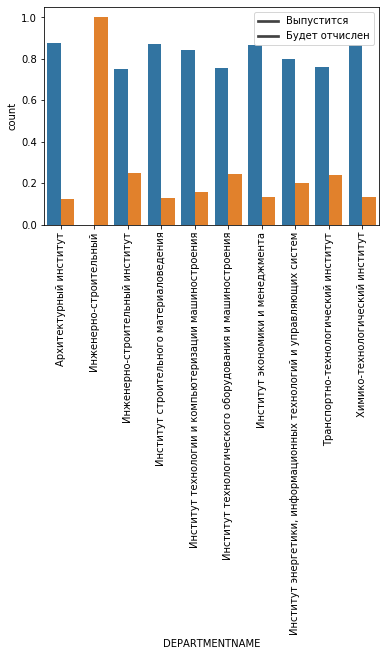

In [827]:
x.columns = ['count']
g = sns.barplot(x='DEPARTMENTNAME', y='count', hue='STATUS', data=x.rename({'STATUS': 'count'}).reset_index())
g.legend(['Выпустится', 'Будет отчислен'])
for tick in g.get_xticklabels():
    tick.set_rotation(90)